# Predicting Ratings

## Text Analysis, User-based Collaborative Filtering, and Simple Averaging



-----------

In [63]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import statsmodels.formula.api as sm
import pandas as pd
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.decomposition import PCA
import json
import gzip
from pandas import Series
from six.moves.html_parser import HTMLParser
from scipy import spatial
import heapq
from sklearn.cross_validation import train_test_split


%matplotlib inline

## Import data

## Text analysis - Class to get Similarity from Text Reviews

In [67]:
class TextSimilarity:
    def __init__(self, data_df): #user_rand_sample_1000.csv
        "Assigns data to data_df property"
        #data_df = pd.read_csv(path)
        print "Shape of our dataset: ", data_df.shape
        print "Number of unique users in the dataset: ",len(np.unique(data_df['reviewerID'].values))
        self.data_df = data_df
        
    def groupByUser(self):
        "Creates a new property data_combined that groups the dataframe by user"
        print "Grouping data by user...."
        data_sample = self.data_df[['reviewText','reviewerID','overall']]
        co2 = self._percentage_coroutine(len(data_sample.groupby('reviewerID')))
        co2.next()
        data_combined = data_sample.groupby('reviewerID').apply(self._trace_progress(self._groupByUser,progress=co2))
        h = HTMLParser()
        remove_html = lambda x: h.unescape(x)
        data_combined['reviewText'] = data_combined['reviewText'].map(remove_html)
        self.data_combined = data_combined
        
    def countWords(self):
        "Applies a count vectorizer and stores result to vectorized"
        vectorizer = CountVectorizer(stop_words = 'english',min_df=4, decode_error="replace")
        reviews = self.data_combined['reviewText'].values
        x = vectorizer.fit_transform(reviews)
        self.vectorized = x.toarray()
        self.all_feature_names = vectorizer.get_feature_names() 
        print len(self.all_feature_names), " unique words found in reviews"
        
    def calculateScores(self):
        "Calculates the TF-IDF based on the vectorized data"
        # Get IDF 
        document_frequency = np.sum(self.vectorized,axis=0)
        print "Calculated Document frequency"
        idf_raw = np.divide(float(self.vectorized.shape[0]),document_frequency)
        idf = np.log10(idf_raw)
        print "Calculated IDF"
        tf = 1 + np.log10(self.vectorized)
        tf[tf<0]=0
        self.tf_idf = np.multiply(tf,idf)


    def _groupByUser(self,x):
        return pd.Series(dict(reviewText = "%s" % ''.join(str(x['reviewText'].values))))
    
    def _trace_progress(self, func, progress = None):
        def callf(*args, **kwargs):
            if (progress is not None):
                progress.send(None)

            return func(*args, **kwargs)

        return callf
    
    def _percentage_coroutine(self, to_process, print_on_percent = 0.25):
        print "Starting progress percentage monitor"
        processed = 0
        count = 0
        print_count = to_process*print_on_percent
        while True:
            yield
            processed += 1
            count += 1
            if (count >= print_count):
                count = 0
                pct = (float(processed)/float(to_process))*100
                print "{}% finished".format(pct)
                
    def _getCosineMatrix(self):
        tf_idf = self.tf_idf
        cosine_sim_results = np.zeros((tf_idf.shape[0],tf_idf.shape[0]))
        for user1 in range(tf_idf.shape[0]):
            for user2 in range(tf_idf.shape[0]):
                cosine_sim_results[user1,user2] = spatial.distance.cosine(tf_idf[user1],tf_idf[user2])
            if user1%20==0: 
                print "Completed ",user1, " users"
                #print float(user1)/tf_idf.shape[0], cosine_sim_results[user1,user2]
        
        self.cosine_sim_results = cosine_sim_results
        
    def getCosineMatrix(self):
        "Returns a matrix of cosine similarity that is N-users by N-users"
        tf_idf = self.tf_idf
        magnitude =  np.linalg.norm(tf_idf, axis=1)
        tf_idf_norm = tf_idf/magnitude[:,None]
        self.cosine_sim_results = tf_idf_norm.dot(tf_idf_norm.T)
        return self.cosine_sim_results                            
                
    def getSimilarityMatrix(self):
        "Returns sorted array of most similar users for each user"
        neighbors = np.zeros((self.cosine_sim_results.shape[0],10))
        count=0
        for row in self.cosine_sim_results[:1000]:
            # get the indices that would sort the row
            # replace values with the index
            # sort the rows
            closest10 = heapq.nlargest(10, range(len(row)), row.take)
            neighbors[count] = closest10
            count+=1
            if count%100==0: print count
        self.neighbors = neighbors
        print "Calculated Similarity Matrix"
        return self.neighbors
    
    def fit(self):
        "Perform all calculations"
        self.groupByUser()
        self.countWords()
        self.calculateScores()
        text_cosine_matrix = self.getCosineMatrix()
        self.getSimilarityMatrix()
        
    def searchReviews(self,search_term): 
        index = self.all_feature_names.index(search_term)
        first_user_with_term = np.argmax(self.vectorized[:,index]>0)
        self.printNeighbors(first_user_with_term)
        #print("We haven't calculated that one yet")
            
    def printNeighbors(self,user):
        for each in self.neighbors[user,0:6]:
            print "\nUser: ", each, "Cosine: ", self.cosine_sim_results[user,each]
            print self.data_combined['reviewText'][int(each)]
            print "--------"

## Load data and split into train and test

In [68]:
data_df = pd.read_csv("frequent_reviews.txt")
data_sample = data_df[['reviewerID','overall','asin','reviewText']]
msk = np.random.rand(len(data_sample)) < 0.3
train = data_sample.copy()
train['overall'][msk] = np.nan
test = data_sample.copy()
test['overall'][~msk] = np.nan

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Get the utility matrix (users vs ratings)

In [69]:
utility_matrix_train = train['overall'].groupby([train['reviewerID'], train['asin']]).mean().unstack()
utility_matrix_test = test['overall'].groupby([test['reviewerID'], test['asin']]).mean().unstack()

In [70]:
utility_matrix_train.shape

(823, 996)

In [71]:
utility_matrix_train_nan = utility_matrix_train
utility_matrix_train = utility_matrix_train.fillna(value=0)
utility_matrix_test_nan = utility_matrix_test
utility_matrix_test = utility_matrix_test.fillna(value=0)

## Get cosine similarity matrix using review text

In [72]:
print(train.shape)
textSimilarity = TextSimilarity(train)
textSimilarity.groupByUser()
textSimilarity.countWords()
textSimilarity.calculateScores()
cosine_matrix_text = textSimilarity.getCosineMatrix()

(14433, 4)
Shape of our dataset:  (14433, 4)
Number of unique users in the dataset:  823
Grouping data by user....
Starting progress percentage monitor
25.0303766707% finished
50.0607533414% finished
75.0911300122% finished
100.121506683% finished
12071  unique words found in reviews
Calculated Document frequency
Calculated IDF


In [75]:
textSimilarity.getSimilarityMatrix()
textSimilarity.printNeighbors(20)

100
200
300
400
500
600
700
800
Calculated Similarity Matrix

User:  20.0 Cosine:  1.0
[ 'I liked very much. This was very well indeed. It was written well. Had a very well story line. Well!!!'
 "This most definitely is a save to my faves. It's a reconnecting love story you have got to read again and again."
 'This read was enjoyable, entertaining, romance. If you love romance get this story. It is one for the faves, ok.'
 'I love to read about true love and this fits the bill. Most definitely worth two thumbs up and a save to faves.'
 "That was very,very,very delightful. Two thumbs up and enjoyable experience. A good save to faves. I don't know what else to say."
 'Even though it was short I liked this very much. I usually like it much more Spicer and a little more story. But it was very good.'
 'Starting over and new beginnings. Thumbs up for Delilah and of course you know me by now. Another add to my faves.'
 "Now that's a story. I enjoyed that so much that I will add it to my faves

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:121: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Get cosine similarity matrix using reviews

In [76]:
# Get the cosine matrix for ratings
# Normalize the utility matrix by dividing by the magnitude of each user vector
magnitude =  np.linalg.norm(utility_matrix_train.values, axis=1)
utility_matrix_norm = np.divide(utility_matrix_train.values,magnitude[:,None])
utility_matrix_norm = np.nan_to_num(utility_matrix_norm) 
cosine_matrix_ratings = utility_matrix_norm.dot(utility_matrix_norm.T)

In [77]:
np.isnan(cosine_matrix_ratings).sum()

0

In [78]:
# Create a version of the utility matrix that has subtracted each user's average rating
values = utility_matrix_train.values
means = np.true_divide(values.sum(1),(values!=0).sum(1))
utility_matrix_rel_zero = (values-means[:,None])*(values!=0)
utility_matrix_rel_zero = np.nan_to_num(utility_matrix_rel_zero)

In [80]:
# Get similarity matrix
neighbors = np.zeros((cosine_matrix_ratings.shape[0],100))
count = 0
for row in cosine_matrix_ratings:
# get the indices that would sort the row
# replace values with the index and sort the rows
    closest100 = heapq.nlargest(100, range(len(row)), row.take)
    neighbors[count] = closest100
    count+=1

In [81]:
neighbors[41]

array([  41.,  667.,  445.,  754.,  210.,  160.,  357.,  757.,   67.,
          0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   54.,
         55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,
         64.,   65.,   66.,   68.,   69.,   70.,   71.,   72.,   73.,
         74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,   82.,
         83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,   91.,   92.])

## Make predictions using text similarity and ratings similarity

In [82]:
import time
def predict(cosine_matrices):
    predictions_all = []
    start = time.clock()
    n_users = utility_matrix_train.shape[0]
    print "start"
    publicRatings = utility_matrix_train_nan.mean().values
    values = utility_matrix_train.values
    means = np.true_divide(values.sum(1),(values!=0).sum(1))
    utility_matrix_boolean = (utility_matrix_train.values>0).astype(int) # Get boolean version of train utility matrix
    for cosine_matrix in cosine_matrices:
        nohistory = 0
        predictions = np.zeros(utility_matrix_train.shape)
        for user in range(n_users):
        #for user in range(10):
            #print time.clock()-start
            indices = utility_matrix_test.values[user]>0 # Books that were rated by the user in the test set
            avgPublicRatings = utility_matrix_train_nan.ix[:,indices].mean().values # avg rating of the public for predict indices
            avgPublicRatings[np.isnan(avgPublicRatings)] = avgPublicRatings[avgPublicRatings>0].mean() # impute missing values
            avgPublicRatings[np.isnan(avgPublicRatings)] = utility_matrix_train_nan.mean().mean()
            avgRating = means[user] # Avg rating for user across all books
            if np.isnan(avgRating): # no user ratings available
                predictions[user,indices] = avgPublicRatings
                nohistory+=1
                #print(user, "no history")
                continue
            myRatings = utility_matrix_rel_zero[user] # Actual Rating for user across all books
            #print time.clock()-start

            cosineTimesBooleanRatings = utility_matrix_boolean * cosine_matrix[user][:,None] # replace utility matrix ratings with cosine scores
            cosineTimesBooleanRatings[user] = np.zeros((predictions.shape[1])) # remove user's row from neighbors calculation
            cosineTimesBooleanRatings_norm =  cosineTimesBooleanRatings/cosineTimesBooleanRatings.sum(axis=0, keepdims=True) # normalize the matrix by dividing by the sum
            cosineTimesBooleanRatings_norm = np.nan_to_num(cosineTimesBooleanRatings_norm) # get rid of nan values
            cosineTimesRatings = utility_matrix_rel_zero * cosineTimesBooleanRatings_norm # element-wise multiplication
            deltaFromNeighbors = np.sum(cosineTimesRatings[:,indices],axis=0)
            noNeighborData = deltaFromNeighbors==0
            # Make prediction
            predictionsToMake = avgRating + 0.8*deltaFromNeighbors
            predictionsToMake[noNeighborData] = 0.6*avgRating + 0.4*avgPublicRatings[noNeighborData]
            predictionsToMake[predictionsToMake>5.0] = 5.0
            predictions[user,indices] = predictionsToMake
            #if np.isnan(predictions[user,:]).sum()>0: print user, "NANS FOUND"; break
            if user%100==0: print user, " users completed"  
            #print time.clock()-start
        predictions_all.append(predictions)
        print "No user history: ", nohistory
    final_predictions = sum(predictions_all)/float(len(predictions_all))
    return predictions_all, final_predictions

In [83]:
predictions_all, predictions = predict([cosine_matrix_text,cosine_matrix_ratings])

start
0  users completed


//anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


100  users completed
300  users completed
400  users completed
500  users completed
600  users completed
700  users completed
800  users completed
No user history:  29
0  users completed
100  users completed
300  users completed
400  users completed
500  users completed
600  users completed
700  users completed
800  users completed
No user history:  29


## Make predictions using simple averaging approach

In [84]:
def predictSimpleAvg():
    predictions_simpleavg = np.zeros(utility_matrix_train.shape)
    publicRatings = utility_matrix_train_nan.mean().values
    values = utility_matrix_train.values
    means = np.true_divide(values.sum(1),(values!=0).sum(1))
    for user in range(predictions_simpleavg.shape[0]):
        indices = utility_matrix_test.values[user]>0 # Books that were rated by the user in the test set
        avgPublicRatings = utility_matrix_train_nan.ix[:,indices].mean().values # avg rating of the public for predict indices
        avgPublicRatings[np.isnan(avgPublicRatings)] = avgPublicRatings[avgPublicRatings>0].mean() # impute missing values
        avgPublicRatings[np.isnan(avgPublicRatings)] = utility_matrix_train_nan.mean().mean()
        avgRating = means[user] # Avg rating for user across all books
        if np.isnan(avgRating): # no user ratings available
            predictions_simpleavg[user,indices] = avgPublicRatings
            #print(user, "no history")
            continue
        predictionsToMake = 0.6*avgRating + 0.4*avgPublicRatings
        #predictionsToMake[predictionsToMake>5.0] = 5.0
        predictions_simpleavg[user,indices] = predictionsToMake
        if np.isnan(predictions_simpleavg[user,:]).sum()>0: print user, "NANS FOUND", avgPublicRatings[avgPublicRatings>0].mean(); break
        if user%100==0: print user, " users completed"    

    return predictions_simpleavg

In [85]:
predictions_simpleAvg = predictSimpleAvg()

0  users completed
100  users completed
300  users completed
400  users completed
500  users completed
600  users completed
700  users completed
800  users completed


#### Check that no predictions are null

In [88]:
np.isnan(predictions_simpleAvg[1]).sum()

0

In [89]:
print(predictions>0).sum()
print(utility_matrix_test.values>0).sum()
predictions_combined_all = 0.25*(predictions_all[0]+predictions_all[1]+predictions+predictions_simpleAvg)

4290
4290


## Get RMSE for all methods

In [90]:
indices_where_history = utility_matrix_train.values.sum(1)>0

In [91]:
all_models = [predictions_all[0], predictions_all[1], predictions, predictions_simpleAvg,predictions_combined_all]
model_names = ["Text Review Similarity", "Ratings Similarity", "Combined Text and Ratings Similarity","Simple Average", "Combined Text, Ratings, and Similarity"]
test_matrix_history_only = utility_matrix_test.values[indices_where_history,:]
for model in range(5):
    print model_names[model]
    squared_error = (all_models[model][indices_where_history,:]-test_matrix_history_only)**2 # just the squared error
    #sq_error_only_rated_books = squared_error*(utility_matrix_test.values>0) # make error 0 for non-rated items
    mse = np.sum(squared_error)/(test_matrix_history_only>0).sum().sum() # average over non-zero ratings
    rmse = mse**0.5 # take square root
    print rmse

Text Review Similarity
0.733816859168
Ratings Similarity
0.74412184859
Combined Text and Ratings Similarity
0.731598498086
Simple Average
0.736580015436
Combined Text, Ratings, and Similarity
0.724892176394


### Plot a histogram of residuals for combined text and ratings similarity methods

In [92]:
error = abs(predictions-utility_matrix_test.values)

In [93]:
predictions_simple = predictions[predictions>0][0:1000]
actual_simple = utility_matrix_test.values[utility_matrix_test.values>0][0:1000]

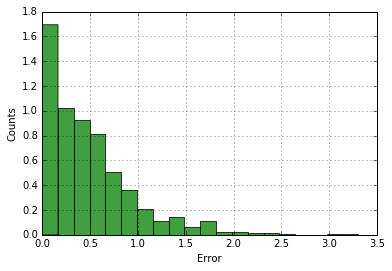

In [94]:
x = abs(predictions_simple - actual_simple)
# the histogram of the data
n, bins, patches = plt.hist(x, 20, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Error')
plt.ylabel('Counts')
plt.grid(True)

plt.show()